In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Model, Sequential
import numpy as np
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)


from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Flatten, GRU,TimeDistributed, Conv1D
from qkeras import *
from tensorflow.keras.models import load_model
from qkeras.utils import model_save_quantized_weights
import os
os.environ['PATH'] = '/tools/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']


2023-01-26 23:43:42.395342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-26 23:43:42.395369: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [3]:
# Load Testing Data
x_test = np.load('./toptag_model/x_test.npy')
y_test = np.load('./toptag_model/y_test.npy')

## Do hls4ml with Keras model

### (a)GRU

In [4]:
gru = load_model('./toptag_model/gru/model_gru.h5')

2023-01-23 17:10:01.030834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-23 17:10:01.030876: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-23 17:10:01.030912: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Dennis-Linux): /proc/driver/nvidia/version does not exist


In [ ]:
gru.compile()
y_gru = gru.predict(x_test)

In [ ]:
print("hls4ml Accuracy: {}".format(roc_auc_score(y_test, y_gru)))

In [6]:
import hls4ml
import plotting
config = hls4ml.utils.config_from_keras_model(gru, granularity='model')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(gru,
                                                       hls_config=config,
                                                       output_dir='model_toptag_gru/hls4ml2int4fra_prj',
                                                       part='xcu250-figd2104-2L-e') 

Interpreting Sequential
Topology:
Layer name: layer1_input, layer type: InputLayer, input shapes: [[None, 20, 6]], output shape: [None, 20, 6]
Layer name: layer1, layer type: GRU, input shapes: [[None, 20, 6]], output shape: [None, 20]
Layer name: layer2, layer type: Dense, input shapes: [[None, 20]], output shape: [None, 64]
Layer name: relu_0, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: layer4, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 1]
Layer name: output_sigmoid, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
-----------------------------------
Configuration
-----------------------------------
Interpreting Sequential
Topology:
Layer name: layer1_input, layer type: InputLayer, input shapes: [[None, 20, 6]], output shape: [None, 20, 6]
Layer name: layer1, layer type: GRU, input shapes: [[None, 20, 6]], output shape: [None, 20]
Layer name: layer2, layer type: Dense, input shapes: [[None

/home/dennis/cyhfiles/hls4ml/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")
/home/dennis/cyhfiles/hls4ml/hls4ml/converters/__init__.py:33: UserWarning: WARNING: ONNX converter is not enabled!
  warnings.warn("WARNING: ONNX converter is not enabled!")


In [ ]:
hls_model.compile()

In [ ]:
hls_model.build(csim=False)

### LSTM

In [4]:
lstm = load_model('./toptag_model/lstm/model_lstm.h5')

In [ ]:
lstm.compile()

In [ ]:
import hls4ml
import plotting
config = hls4ml.utils.config_from_keras_model(lstm, granularity='model')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(lstm,
                                                       hls_config=config,
                                                       output_dir='model_toptag_lstm/hls4ml2int4fra_prj',
                                                       part='xcu250-figd2104-2L-e') 

In [ ]:
hls_model.compile()

In [ ]:
hls_model.build(csim=False)

## Do hls4ml with Qkeras model

### (a) QGRU

In [4]:
gru = Sequential()
gru.add(GRU(20, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001), name = 'layer1', input_shape = (20,6)))
gru.add(Dense(64,  kernel_initializer='glorot_normal', name='layer2')) #kernel_regularizer = regularizers.l1_l2(l1= 0.0001, l2 = 0.0001),
gru.add(Activation('relu', name = 'relu_0'))
gru.add(Dense(1, name = 'layer4'))
gru.add(Activation('sigmoid', name = 'output_sigmoid'))
gru.summary()

2023-01-23 13:43:27.578899: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-23 13:43:27.578948: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-23 13:43:27.578984: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Dennis-Linux): /proc/driver/nvidia/version does not exist


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (GRU)                 (None, 20)                1680      
_________________________________________________________________
layer2 (Dense)               (None, 64)                1344      
_________________________________________________________________
relu_0 (Activation)          (None, 64)                0         
_________________________________________________________________
layer4 (Dense)               (None, 1)                 65        
_________________________________________________________________
output_sigmoid (Activation)  (None, 1)                 0         
Total params: 3,089
Trainable params: 3,089
Non-trainable params: 0
_________________________________________________________________


In [5]:
## Load qkeras weight back into keras model
qgru = load_model('./toptag_model/qgru_2int/model_qgru_4frac.h5', custom_objects={'QGRU':QGRU,'QDense':QDense,'quantized_bits': quantized_bits, 'QActivation': QActivation})
model_save_quantized_weights(qgru, "gru22test.h5")
gru.load_weights('gru22test.h5')


... quantizing model


In [5]:
gru.compile()
y_gru = gru.predict(x_test)

In [18]:
print("hls4ml Accuracy: {}".format(roc_auc_score(y_test, y_gru)))

hls4ml Accuracy: 0.9294431894435856


In [7]:
import hls4ml
import plotting
config = hls4ml.utils.config_from_keras_model(lstm, granularity='model')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(lstm,
                                                       hls_config=config,
                                                       output_dir='model_toptag_lstm/hls4ml2int4fra_prj',
                                                       part='xcu250-figd2104-2L-e') 

Interpreting Sequential
Topology:
Layer name: layer1_input, layer type: InputLayer, input shapes: [[None, 20, 6]], output shape: [None, 20, 6]
Layer name: layer1, layer type: LSTM, input shapes: [[None, 20, 6]], output shape: [None, 20]
Layer name: layer3, layer type: Dense, input shapes: [[None, 20]], output shape: [None, 64]
Layer name: relu_0, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: layer5, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 1]
Layer name: output_sigmoid, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
-----------------------------------
Configuration
-----------------------------------
Interpreting Sequential
Topology:
Layer name: layer1_input, layer type: InputLayer, input shapes: [[None, 20, 6]], output shape: [None, 20, 6]
Layer name: layer1, layer type: LSTM, input shapes: [[None, 20, 6]], output shape: [None, 20]
Layer name: layer3, layer type: Dense, input shapes: [[No

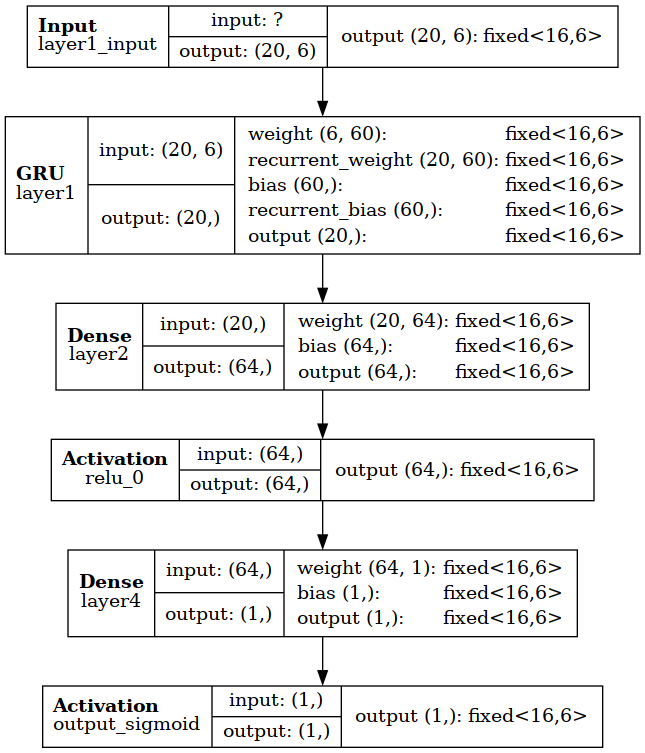

In [7]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [8]:
hls_model.compile()
# X_test = np.ascontiguousarray(x_test)
# y_hls = hls_model.predict(x_test)

Writing HLS project
Done


In [11]:
print("qkeras Accuracy: {}".format(roc_auc_score(y_test, y_gru)))
print("hls4ml Accuracy: {}".format(roc_auc_score(y_test,y_hls)))

NameError: name 'y_gru' is not defined

In [10]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'dennis' on host 'Dennis-Linux' (Linux_x86_64 version 4.15.0-202-generic) on Fri Jan 27 01:13:42 PST 2023
INFO: [HLS 200-10] On os Ubuntu 18.04.6 LTS
INFO: [HLS 200-10] In directory '/home/dennis/cyhfiles/hls4ml-rnnpaper/model_toptag_lstm/hls4ml2int4fra_prj'
Sourcing Tcl script 'build_prj.tcl'
expected boolean value but got "Falsecsim"
    while executing
"if {$opt(reset)} {
    open_project -reset ${project_name}_prj
} else {
    open_project ${project_name}_prj
}"
    (file "build_prj.tcl" line 149)
    invoked from within
"source build_prj.t

{}

In [18]:
hls4ml.report.read_vivado_report('model_toptag_gru/hls4ml2int4fra_prj/')

Project myproject_prj does not exist. Rerun "hls4ml build -p model_toptag_gru/hls4ml2int4fra_prj/".


### (b) QLSTM

In [3]:
lstm = Sequential()
lstm.add(LSTM(20, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001),
               name = 'layer1', input_shape = (20,6)))
lstm.add(Dense(64, kernel_initializer='glorot_normal', name='layer2'))
lstm.add(Activation('relu', name = 'relu_0'))
lstm.add(Dense(1, name = 'layer5'))
model.add(Activation('sigmoid', name = 'output_sigmoid'))
model.summary()

2023-01-26 23:43:58.360939: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-26 23:43:58.360974: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-26 23:43:58.361001: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Dennis-Linux): /proc/driver/nvidia/version does not exist


NameError: name 'model' is not defined

In [11]:
## Load qkeras weight back into keras model
qlstm = load_model('./toptag_model/qlstm_2int/model_qlstm_4frac.h5', custom_objects={'QLSTM':QLSTM,'QDense':QDense,'quantized_bits': quantized_bits, 'QActivation': QActivation})
model_save_quantized_weights(qlstm, "lstm22test.h5")
lstm.load_weights('lstm22test.h5')

In [10]:
import hls4ml
config = hls4ml.utils.config_from_keras_model(lstm, granularity='model')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(lstm,
                                                       hls_config=config,
                                                       output_dir='model_1/hls4ml_prj',
                                                       part='xcu250-figd2104-2L-e') 

Interpreting Sequential
Topology:
Layer name: layer1_input, layer type: InputLayer, input shapes: [[None, 20, 6]], output shape: [None, 20, 6]
Layer name: layer1, layer type: LSTM, input shapes: [[None, 20, 6]], output shape: [None, 20]
Layer name: layer3, layer type: Dense, input shapes: [[None, 20]], output shape: [None, 64]
Layer name: relu_0, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: layer5, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 1]
Layer name: output_sigmoid, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
-----------------------------------
Configuration
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
-----------------------------------
Interpreting Sequential
Topology:
Layer name: layer1_input, layer type: InputLayer, input shapes: [[None, 20, 6]], output shape: [None, 20, 6]
L

In [ ]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [ ]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)


In [ ]:
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

In [ ]:
hls_model.build(csim=False)